In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ROOT
import uproot
from tqdm import tqdm
ROOT.gStyle.SetOptStat(0000)

Welcome to JupyROOT 6.28/00


# Matrix diagonalization

In [3]:
# in case matrix is not symmetric due to digital-only problem
def matrix_digit_regularization(cov):                    
    for i in range(len(cov)):
        for j in range(len(cov[i])): 
            if j>i:
                cov[i,j] = cov[j,i]


def is_symmetric(matrix):
    elementwise_compre  = matrix == matrix.conjugate().T
    if any(elementwise_compre.flatten() == False):
        print('matrix is not symmetric!')
    else:
        print('matrix is symmetric!')

In [4]:
# reading pull and covariance matrix
df_cov = pd.read_csv('cov.csv', index_col=0)
df_np = pd.read_csv('np.csv', index_col=0)

In [5]:
# finding columns which is neither pulled or constrained (not necessary to be dropped but just for compution simplicity)
# one can also keep these uncorrelatrd NPs, as this new dimension is reduciable, the redcompiosition will just return eigenvalue of 1 and eigenvector of (0, ..., 0, 1) -> invariant before and after decomposition 
unconst_columns = df_cov.columns[((df_cov == 0).sum(axis=0) == len(df_cov.columns)-1) & ((df_cov == 0).sum(axis=1) == len(df_cov.columns)-1) & (np.diag(df_cov.values)==1)]
unpull_column = df_np.columns[(df_np == 0).sum(axis=0) == 1]
cols_to_drop = np.intersect1d(unconst_columns, unpull_column)

print('dropping columns:', cols_to_drop)

dropping columns: ['EG_SCALE_E4SCINTILLATOR__ETABIN0__1up'
 'EG_SCALE_E4SCINTILLATOR__ETABIN1__1up' 'EG_SCALE_PS__ETABIN7__1up']


In [6]:
df_np = df_np.drop(columns=cols_to_drop)
df_np.to_csv("np_skim.csv")

df_cov = df_cov.drop(index=cols_to_drop, columns=cols_to_drop)
df_cov.to_csv("cov_skim.csv")

In [7]:
print('shape of np:', df_np.shape)
cov = df_cov.values
is_symmetric(cov)
# usually just digit problem, can be manually set to symmetric, but this step is not necessary if using lingalg.eigh
print('manually set to symmetric (can be turned off if using lingalg.eigh)') 
matrix_digit_regularization(cov)
is_symmetric(cov)

shape of np: (1, 46)
matrix is not symmetric!
manually set to symmetric (can be turned off if using lingalg.eigh)
matrix is symmetric!


In [8]:
print('store orignal and shortcutted labels for NPs')
labels0 = list(df_cov.columns)
labels = []
for i in range(len(labels0)):
    labels.append(labels0[i].replace('EG_SCALE_', '').replace('__1up', '').replace('BIN', ''))
    
labels_new = ['EV_'+str(i)  for i in range(len(labels))]
labels_new_prime = ['EG_SCALE_EV_'+str(i)+'__1up'  for i in range(len(labels))]
    
print('first 5 NPs names (original):', labels0[:5])
print('first 5 NPs names (shortcut):', labels[:5])

store orignal and shortcutted labels for NPs
first 5 NPs names (original): ['EG_SCALE_ADCLIN__1up', 'EG_SCALE_E4SCINTILLATOR__ETABIN2__1up', 'EG_SCALE_G4__1up', 'EG_SCALE_L1GAIN__1up', 'EG_SCALE_L2MEDIUMGAIN__1up']
first 5 NPs names (shortcut): ['ADCLIN', 'E4SCINTILLATOR__ETA2', 'G4', 'L1GAIN', 'L2MEDIUMGAIN']


plotting covariance matrix


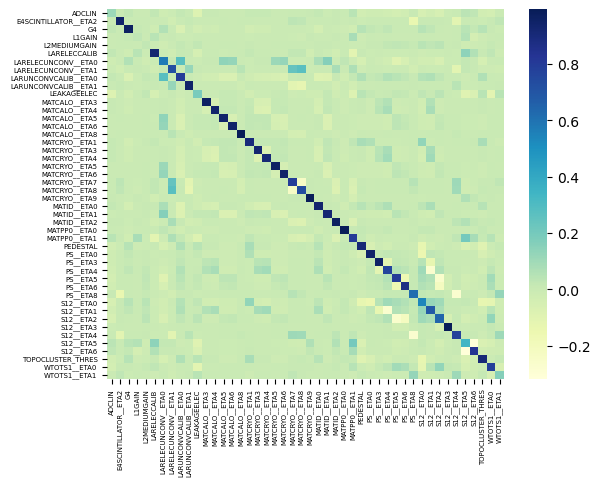

In [9]:
print('plotting covariance matrix')

ax=sns.heatmap(cov, annot=False, xticklabels = labels, yticklabels = labels, fmt=".1f", cmap="YlGnBu")
size = 5
plt.yticks(fontsize=size)
plt.xticks(fontsize=size)
# ax.use_sticky_edges

plt.savefig('cov.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
def is_diagonalizable(A):
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    rank = np.linalg.matrix_rank(eigenvectors)
    if rank == A.shape[0]:
        return True
    else:
        return False
    
def diagonalize_matrix(A, DecreaseOrder=True, normalize=True):
    if not is_diagonalizable(A):
        return "Matrix A is not diagonalizable"

    # Step 2: Calculate eigenvalues
    eigenvalues, P = np.linalg.eigh(A)
    if DecreaseOrder:
        eigenvalues = np.flip(eigenvalues)
        P = np.flip(P, axis=1)
        
    D = np.diag(eigenvalues)


    if normalize:
        P = P @ np.diag(1.0 / np.sqrt(np.diag(D))) 
        
    return [P, D]

In [11]:
# eigenvector matrix and eigenvalue matrix
P, D = diagonalize_matrix(cov)

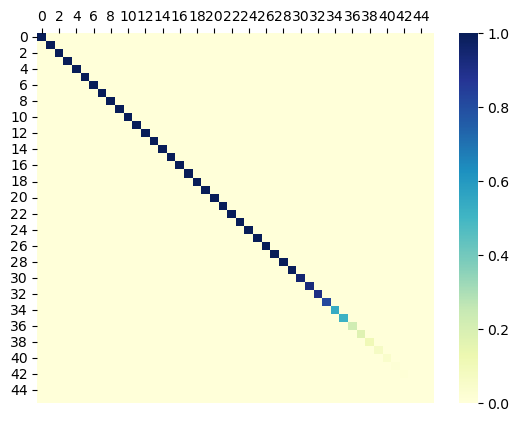

eigenvalues: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.99999995
 0.99999989 0.99999983 0.99999923 0.99999905 0.99999568 0.9999944
 0.99999315 0.99997383 0.99992577 0.99986173 0.99965062 0.9994944
 0.99929919 0.99923015 0.99907654 0.9981672  0.99513465 0.99334093
 0.94653924 0.92636999 0.90656686 0.81414693 0.53832113 0.51451108
 0.22121483 0.17398081 0.10834773 0.06798861 0.0438721  0.01292446
 0.01128333 0.00388966 0.00178369 0.0014215 ]


In [12]:
ax=sns.heatmap(D, annot=False, fmt=".1f", cmap="YlGnBu")
ax.xaxis.tick_top()
plt.savefig('eigenvalues.pdf', bbox_inches='tight', dpi=1000)
plt.show()

print('eigenvalues:', np.diag(D))


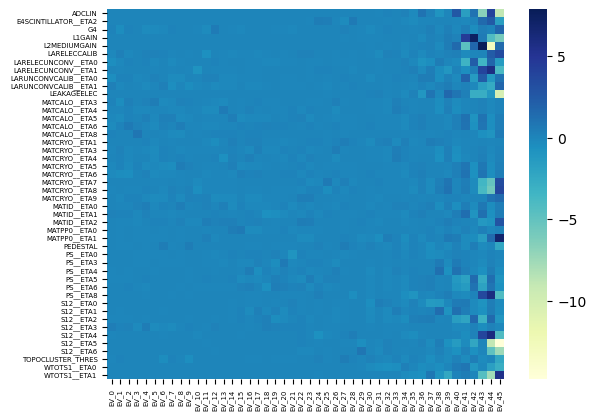

In [13]:
ax=sns.heatmap(P, annot=False, xticklabels = labels_new, yticklabels = labels, cmap="YlGnBu")
# ax.xaxis.tick_top()
size = 5
plt.yticks(fontsize=size)
plt.xticks(fontsize=size)

ax.use_sticky_edges
plt.savefig('P_PRIME.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
df_final_P = pd.DataFrame(P, index=labels_new_prime, columns=labels0)
df_final_P.to_csv('final_P.csv')

In [15]:
df = pd.read_csv('final_P.csv', index_col=0)

In [16]:
df.head()

EG_SCALE_ADCLIN__1up  \
EG_SCALE_EV_0__1up              0.000000   
EG_SCALE_EV_1__1up             -0.004142   
EG_SCALE_EV_2__1up              0.088619   
EG_SCALE_EV_3__1up              0.000056   
EG_SCALE_EV_4__1up              0.000063   

                    EG_SCALE_E4SCINTILLATOR__ETABIN2__1up  EG_SCALE_G4__1up  \
EG_SCALE_EV_0__1up                               0.000000          0.000000   
EG_SCALE_EV_1__1up                               0.003038         -0.000713   
EG_SCALE_EV_2__1up                              -0.418459          0.152019   
EG_SCALE_EV_3__1up                               0.000258         -0.000083   
EG_SCALE_EV_4__1up                               0.000041          0.000051   

                    EG_SCALE_L1GAIN__1up  EG_SCALE_L2MEDIUMGAIN__1up  \
EG_SCALE_EV_0__1up              0.000000                    0.000000   
EG_SCALE_EV_1__1up              0.001451                    0.004027   
EG_SCALE_EV_2__1up             -0.001133                   -0.280700   
EG_SCALE_EV_3__1up             -0.000282                   -0.000163   
EG_SCALE_EV_4__1up             -0.000121                   -0.000120   

                    EG_SCALE_LARELECCALIB__1up  \
EG_SCALE_EV_0__1up                   -0.000470   
EG_SCALE_EV_1__1up                    0.001497   
EG_SCALE_EV_2__1up                   -0.237270   
EG_SCALE_EV_3__1up                   -0.000219   
EG_SCALE_EV_4__1up                   -0.000231   

                    EG_SCALE_LARELECUNCONV__ETABIN0__1up  \
EG_SCALE_EV_0__1up                              0.000000   
EG_SCALE_EV_1__1up                             -0.004670   
EG_SCALE_EV_2__1up                             -0.119936   
EG_SCALE_EV_3__1up                              0.000103   
EG_SCALE_EV_4__1up                             -0.000066   

                    EG_SCALE_LARELECUNCONV__ETABIN1__1up  \
EG_SCALE_EV_0__1up                              0.000000   
EG_SCALE_EV_1__1up                              0.008009   
EG_SCALE_EV_2__1up                              0.112470   
EG_SCALE_EV_3__1up                             -0.000100   
EG_SCALE_EV_4__1up                             -0.000034   

                    EG_SCALE_LARUNCONVCALIB__ETABIN0__1up  \
EG_SCALE_EV_0__1up                               0.000000   
EG_SCALE_EV_1__1up                               0.000602   
EG_SCALE_EV_2__1up                               0.063134   
EG_SCALE_EV_3__1up                              -0.000215   
EG_SCALE_EV_4__1up                              -0.000170   

                    EG_SCALE_LARUNCONVCALIB__ETABIN1__1up  ...  \
EG_SCALE_EV_0__1up                               0.000000  ...   
EG_SCALE_EV_1__1up                               0.006631  ...   
EG_SCALE_EV_2__1up                               0.016221  ...   
EG_SCALE_EV_3__1up                              -0.000075  ...   
EG_SCALE_EV_4__1up                               0.000057  ...   

                    EG_SCALE_S12__ETABIN0__1up  EG_SCALE_S12__ETABIN1__1up  \
EG_SCALE_EV_0__1up                    0.978497                    0.212563   
EG_SCALE_EV_1__1up                   -0.040020                   -0.018167   
EG_SCALE_EV_2__1up                    0.043028                    0.320429   
EG_SCALE_EV_3__1up                   -0.199511                    0.175648   
EG_SCALE_EV_4__1up                    0.089868                    0.205092   

                    EG_SCALE_S12__ETABIN2__1up  EG_SCALE_S12__ETABIN3__1up  \
EG_SCALE_EV_0__1up                   -0.823818                   -0.017523   
EG_SCALE_EV_1__1up                    0.020721                    0.030030   
EG_SCALE_EV_2__1up                   -0.132090                    0.261414   
EG_SCALE_EV_3__1up                    0.024544                    0.434828   
EG_SCALE_EV_4__1up                   -0.224463                    0.484105   

                    EG_SCALE_S12__ETABIN4__1up  EG_SCALE_S12__ETABIN5__1up  \
EG_SCALE_EV_0__1up                    2.5717

In [17]:
print(np.allclose(P @ D @np.linalg.inv(P), cov), np.allclose(P.T @ cov @ P, np.identity(len(cov)))) 

True True


# NP reduction

In [18]:
def Arr2DtoTH2D(arr):
    h2d = ROOT.TH2D('cov', '', len(arr), 0, len(arr), len(arr), 0, len(arr))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            h2d.SetBinContent(i+1, j+1, arr[i][j])
            h2d.SetBinError(i+1, j+1, 0)
    return h2d

def TH2DtoArr1D(h2d, mask_diag=True):
    arr = np.zeros((h2d.GetNbinsX(), h2d.GetNbinsY()))
    for i in range(h2d.GetNbinsX()):
        for j in range(h2d.GetNbinsY()):
            arr[i][j] = h2d.GetBinContent(i+1, j+1)
    # if filter the diagonal
    if mask_diag:
        mask = np.ones(arr.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        # select all non-diagonal elements
        arr = arr[mask]
    return arr

In [19]:
def get_cor(h_cov):
    h_cor = h_cov.Clone()
    for i in range(h_cov.GetNbinsX()):
        for j in range(h_cov.GetNbinsY()):
            bin_ij = h_cov.GetBinContent(i+1,j+1)/np.sqrt(h_cov.GetBinContent(i+1,i+1)*h_cov.GetBinContent(j+1,j+1))
            h_cor.SetBinContent(i+1,j+1,bin_ij)
            h_cor.SetBinError(i+1,j+1,0)
    return h_cor

def get_err(h_cov, name):
    h_err = ROOT.TH1D(name, '', h_cov.GetNbinsX(), 0, h_cov.GetNbinsX())
    for i in range(h_cov.GetNbinsX()):
        h_err.SetBinContent(i+1, np.sqrt(h_cov.GetBinContent(i+1,i+1)))
        h_err.SetBinError(i+1, 0)
    return h_err

In [20]:
def cov_to_cor(cov):
    sigma_inv = 1./np.sqrt(np.diag(cov))
    sigmaij_inv = np.outer(sigma_inv, sigma_inv)
    cor = cov * sigmaij_inv
    return cor

In [21]:
color_pal = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
color_root = [ROOT.TColor.GetColor(col) for col in color_pal]

Info in <TCanvas::Print>: pdf file error_compare.pdf has been created


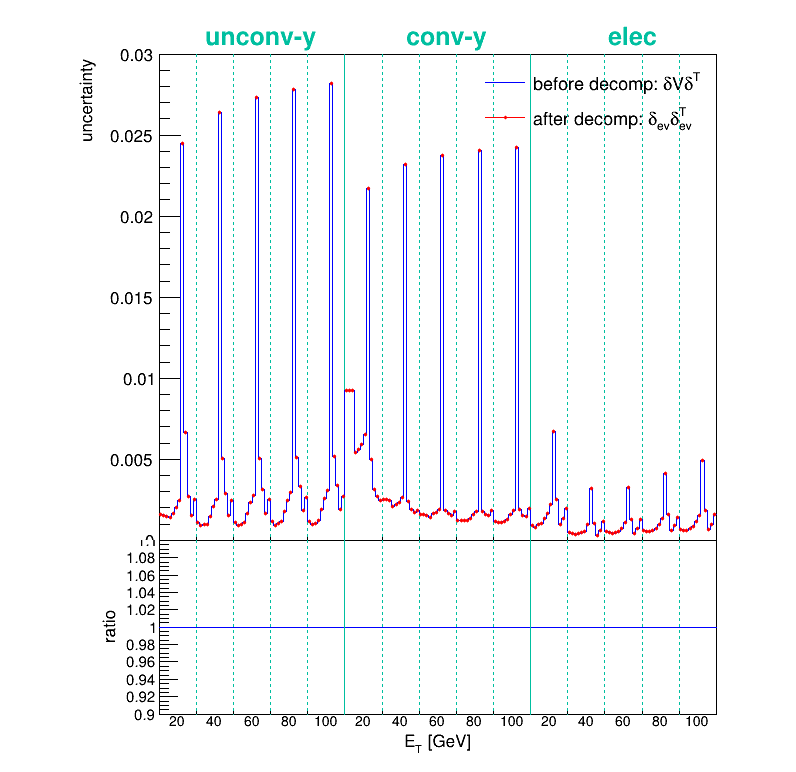

In [22]:
# Open the systematic files
f_before = ROOT.TFile('syst_results/test.root')
f_ev = ROOT.TFile('syst_results/test_ev.root')

# Create a canvas
c = ROOT.TCanvas("c", "canvas", 800, 800)
c.Draw()

# Create two pads
top_pad = ROOT.TPad("top_pad", "", 0, 0.3, 1, 1)
bottom_pad = ROOT.TPad("bottom_pad", "", 0, 0, 1, 0.3)

# Set pad margins
top_pad.SetBottomMargin(0)
bottom_pad.SetTopMargin(0)
bottom_pad.SetBottomMargin(0.25)
top_pad.SetLeftMargin(0.2)
bottom_pad.SetLeftMargin(0.2)

# Draw pads
top_pad.Draw()
bottom_pad.Draw()

# Draw histograms on the top pad
top_pad.cd()
h_err_before = get_err(f_before.Get('EG_SCALE_cov'), 'before')
h_err_before.SetLineColor(4)
h_err_before.GetYaxis().SetRangeUser(0, 0.03)
h_err_before.Draw('hist')
h_err_before.GetXaxis().SetNdivisions(1500)

h_err_ev = get_err(f_ev.Get('EG_SCALE_cov'), 'ev')
h_err_ev.SetLineColor(2)
h_err_ev.SetMarkerColor(2)
h_err_ev.SetMarkerStyle(20)
h_err_ev.SetMarkerSize(0.3)
h_err_ev.Draw('same P')

# Set y-axis title
h_err_before.GetYaxis().SetTitle("uncertainty")

# Draw the upper x-axis with 4 ticks at x=0, 60, 120, 180
axis = ROOT.TGaxis(0, 0.03, 180, 0.03, 0, 180, 510, "-L")
axis.SetLabelSize(0)
axis.SetNdivisions(300)
axis.Draw()

col = color_root[-1]

# Draw text "unconv-y", "conv-y", "elec" in red color between the ticks
labels = ["unconv-y", "conv-y", "elec"]
x_positions = [15, 80, 145]
arr_text=[]
for i, label in enumerate(labels):
    text = ROOT.TText(x_positions[i], 0.0305, label)
    text.SetTextColor(col)
    arr_text.append(text)
    arr_text[-1].Draw()

# Draw the legend
legend = ROOT.TLegend(0.6, 0.75, 0.88, 0.88)
legend.AddEntry(h_err_before, "before decomp: #deltaV#delta^{T}", "l")
legend.AddEntry(h_err_ev, "after decomp: #delta_{ev}#delta_{ev}^{T}", "lp")
legend.SetBorderSize(0)
legend.Draw()

arr_line=[]
for x in np.linspace(0+12, 180-12, 14):
    line = ROOT.TLine(x, 0, x, 0.03)
    line.SetLineColor(col)
    if x not in [60, 120]:
        line.SetLineStyle(2)
    arr_line.append(line)
    arr_line[-1].Draw()
    
h_err_before.Draw('hist same')
h_err_ev.Draw('same P')    

# Calculate the ratio of the two histograms
h_ratio = h_err_before.Clone()
h_ratio.Divide(h_err_ev)

# Draw the ratio histogram on the bottom pad
bottom_pad.cd()
hf = bottom_pad.DrawFrame(0, 0.9, 180, 1.1)
hf.GetYaxis().SetRangeUser(0.9, 1.1)
hf.GetYaxis().CenterTitle()
hf.GetYaxis().SetTitle("ratio")
hf.GetYaxis().SetTitleSize(0.08)
hf.GetYaxis().SetLabelSize(0.07)
hf.GetXaxis().SetLabelSize(0.07)
hf.GetYaxis().SetTitleOffset(0.5)
hf.GetXaxis().SetNdivisions(1500)
hf.GetXaxis().SetTitle('E_{T} [GeV]')
hf.GetXaxis().CenterTitle()
hf.GetXaxis().SetTitleSize(0.08)
hf.GetXaxis().SetLabelSize(0.1)

hf.SetLineColor(0)
hf.Draw()

hf.SetBins(15, 0, 180)
pt_low = 20.
pt_high = 100.
nbins_pt = 5
arr_pt_centers = np.linspace(pt_low, pt_high, nbins_pt)

for i in range(15):
    ipt = i%5
    hf.GetXaxis().SetBinLabel(i+1, f'{arr_pt_centers[ipt]:.0f}')

h_ratio.GetYaxis().SetRangeUser(0.9, 1.1)
h_ratio.Draw("hist same")


arr_line2=[]
for x in np.linspace(0+12, 180-12, 14):
    line = ROOT.TLine(x, 0.9, x, 1.1)
    line.SetLineColor(col)
    if x not in [60, 120]:
        line.SetLineStyle(2)
    arr_line2.append(line)
    arr_line2[-1].Draw()
    
# Update the canvas
c.Update()
c.SaveAs('error_compare.pdf')

--> max change by a factor of +1.00000000000000000000, -1.00000000000000000000
--> average change by a factor of 1.00000000000000000000


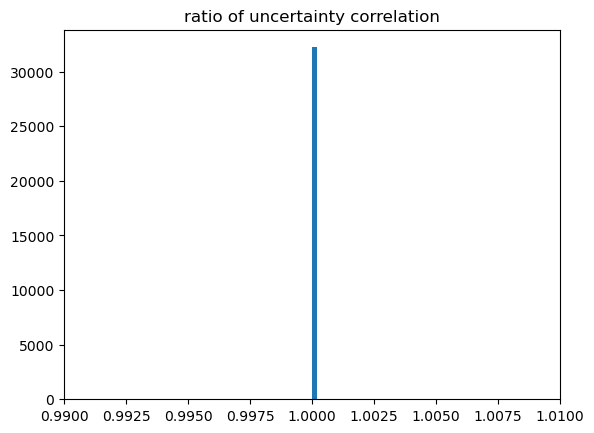

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file corr_compare.pdf has been created


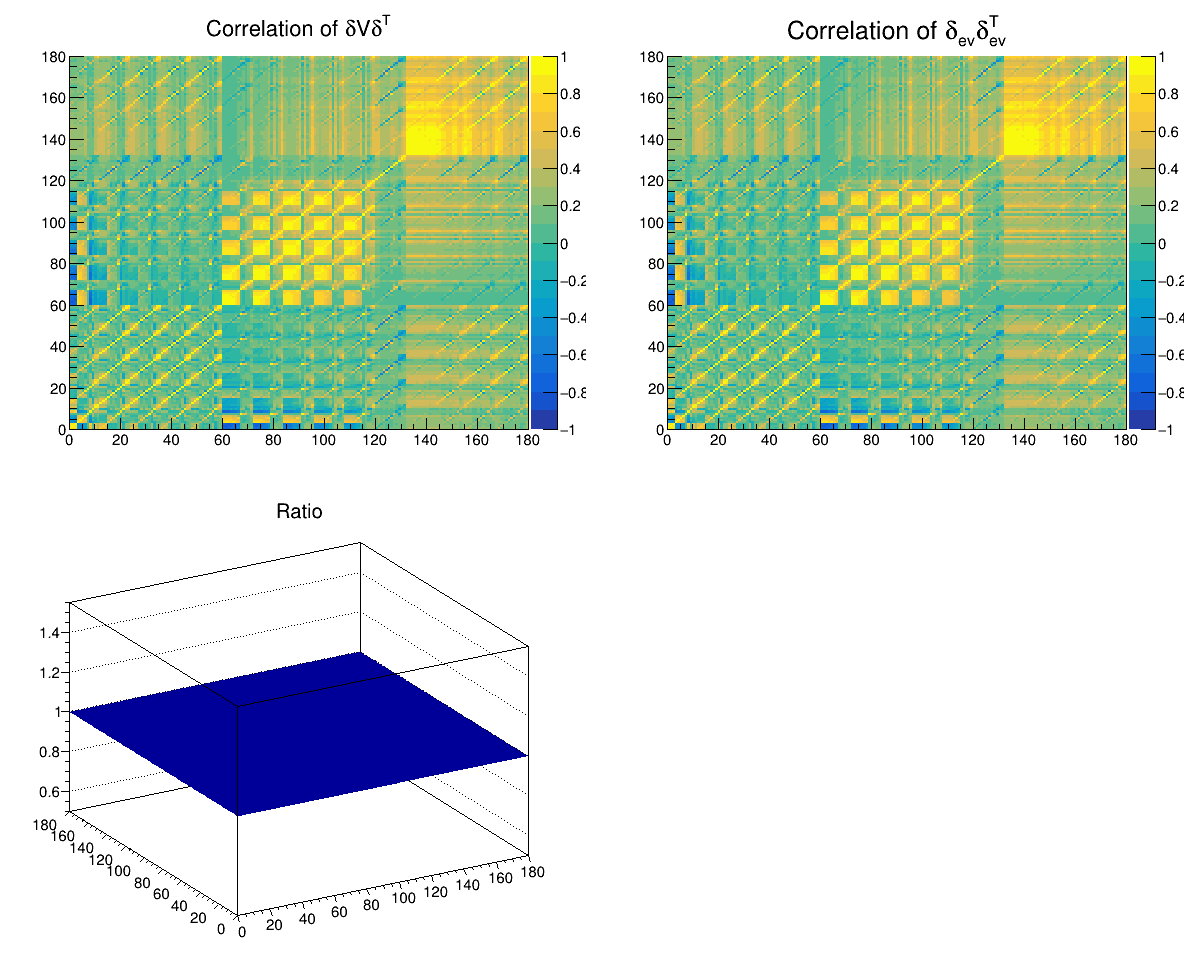

In [23]:
f_before = ROOT.TFile('syst_results/test.root')
f_ev = ROOT.TFile('syst_results/test_ev.root')

c = ROOT.TCanvas('c', '', 1200, 1000)
c.Divide(2,2)
c.Draw()
# c.SetLogz()
c.cd(1)
cor_before = get_cor(f_before.Get('EG_SCALE_cov'))
cor_before.SetTitle('Correlation of #deltaV#delta^{T}')
cor_before.GetZaxis().SetRangeUser(-1, 1)
cor_before.Draw('colz')

c.cd(2)
cor_ev = get_cor(f_ev.Get('EG_SCALE_cov'))
cor_ev.SetTitle('Correlation of #delta_{ev}#delta_{ev}^{T}')
cor_ev.GetZaxis().SetRangeUser(-1, 1)
cor_ev.Draw('colz')

c.cd(3)
cor_ratio = cor_ev.Clone()
cor_ratio.Divide(cor_before)
cor_ratio.SetTitle('Ratio')
cor_ratio.GetZaxis().SetRangeUser(0.5, 1.5)
cor_ratio.Draw('surf')

c.SaveAs('corr_compare.pdf')


arr_ratio = TH2DtoArr1D(cor_ratio, True)
rmax, rmin, ravg = max(arr_ratio), min(arr_ratio), np.mean(arr_ratio)
fig = plt.figure()
plt.hist(arr_ratio, bins=100, range=(rmin-0.01, rmax+0.01))
plt.title('ratio of uncertainty correlation')
# plt.savefig(f'{folder}EV_{ev_index}.png')
plt.xlim(rmin-0.01, rmax+0.01)
print(f'--> max change by a factor of +{rmax:.20f}, -{rmin:.20f}')
print(f'--> average change by a factor of {ravg:.20f}')
plt.show()

In [24]:
# get all EV NPs
folder = 'output/NP_reduction/'
f_ev = uproot.open('syst_results/test_ev.root')
# ev NPs
arr_NP_ev = []
for key in f_ev.keys():
    if '_EV_' in key:
        arr_NP_ev.append(key)

EG_SCALE_EV_0__1up;1


Text(0.5, 0, 'bin')

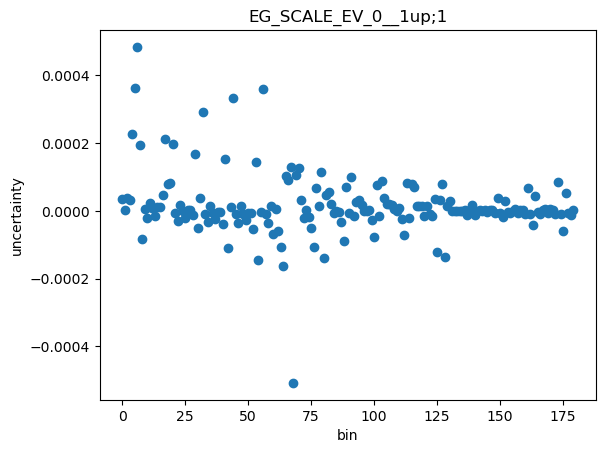

In [25]:
hist_name = arr_NP_ev[0]
print(hist_name)
vals = f_ev[hist_name].values()
plt.scatter(np.arange(len(vals)), vals)
plt.title(hist_name)
plt.ylabel('uncertainty')
plt.xlabel('bin')

In [26]:
def run_NP_reduction(ev_index):
    f_ev = uproot.open('syst_results/test_ev.root')
    # f_before = uproot.open('syst_results/test.root')
    keys_del = ['EG_SCALE_cov;1', arr_NP_ev[ev_index]]

    arr_allkeys = f_ev.keys()
    for key in keys_del:
        arr_allkeys.remove(key)

    arr_values = np.array([f_ev[key].values() for key in arr_allkeys])
    cov_new = arr_values.T @ arr_values
    cor_new = cov_to_cor(cov_new)

    cov_before = f_ev['EG_SCALE_cov'].values()
    cor_before = cov_to_cor(cov_before)

    cor_ratio = cor_new/cor_before
    mask = np.ones(cor_ratio.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    # select all non-diagonal elements
    arr_ratio = cor_ratio[mask]

    rmax, rmin, ravg = max(arr_ratio), min(arr_ratio), np.mean(arr_ratio)
    fig = plt.figure()
    plt.hist(arr_ratio, bins=100, range=(rmin, rmax))
    plt.title(f'Remove {arr_NP_ev[ev_index]}')
    plt.savefig(f'{folder}EV_{ev_index}.png')
    plt.close()

    output = {
        'max_ratio': rmax,
        'min_ratio': rmin,
        'max_abs_ratio': max([abs(rmax), abs(rmin)]),
        'avg_ratio': ravg
    }

    return output#[rmax, rmin, ravg]

In [27]:
results={}
for i in tqdm(range(len(arr_NP_ev))):
    results[arr_NP_ev[i].replace(';1', '')] = run_NP_reduction(i)

100%|██████████| 46/46 [00:10<00:00,  4.35it/s]


In [28]:
df = pd.DataFrame.from_dict(results)

In [29]:
df

EG_SCALE_EV_0__1up  EG_SCALE_EV_1__1up  EG_SCALE_EV_2__1up  \
max_ratio               10.220558           22.234939           47.911451   
min_ratio              -49.154123          -40.288156           -0.820522   
max_abs_ratio           49.154123           40.288156           47.911451   
avg_ratio                0.996292            0.998344            1.006782   

               EG_SCALE_EV_3__1up  EG_SCALE_EV_4__1up  EG_SCALE_EV_5__1up  \
max_ratio               79.815441           26.209832           10.977465   
min_ratio              -31.705408          -79.408685           -3.583276   
max_abs_ratio           79.815441           79.408685           10.977465   
avg_ratio                1.006877            0.997128            1.003867   

               EG_SCALE_EV_6__1up  EG_SCALE_EV_7__1up  EG_SCALE_EV_8__1up  \
max_ratio               17.075242           64.406538           46.194335   
min_ratio              -30.980334           -8.053838         -112.503351   
max_abs_ratio           30.980334           64.406538          112.503351   
avg_ratio                1.001985            1.004134            0.995182   

               EG_SCALE_EV_9__1up  ...  EG_SCALE_EV_36__1up  \
max_ratio               16.814042  ...            93.870294   
min_ratio              -39.391321  ...          -296.047793   
max_abs_ratio           39.391321  ...           296.047793   
avg_ratio                1.002597  ...             0.982461   

               EG_SCALE_EV_37__1up  EG_SCALE_EV_38__1up  EG_SCALE_EV_39__1up  \
max_ratio                99.549569           281.067066            22.869989   
min_ratio               -13.486326           -43.849583          -172.230472   
max_abs_ratio            99.549569           281.067066           172.230472   
avg_ratio                 1.015678             1.030464             0.997905   

               EG_SCALE_EV_40__1up  EG_SCALE_EV_41__1up  EG_SCALE_EV_42__1up  \
max_ratio               133.259408            76.479066             9.701263   
min_ratio               -12.354647           -21.698577           -98.190498   
max_abs_ratio           133.259408            76.479066            98.190498   
avg_ratio                 1.018072             1.005062             0.997163   

               EG_SCALE_EV_43__1up  EG_SCALE_EV_44__1up  EG_SCALE_EV_45__1up  
max_ratio                11.767301            42.300463             7.526526  
min_ratio               -71.818400            -4.753209            -0.407441  
max_abs_ratio            71.818400            42.300463             7.526526  
avg_ratio                 0.997608             1.002274             1.000559  

[4 rows x 46 columns]

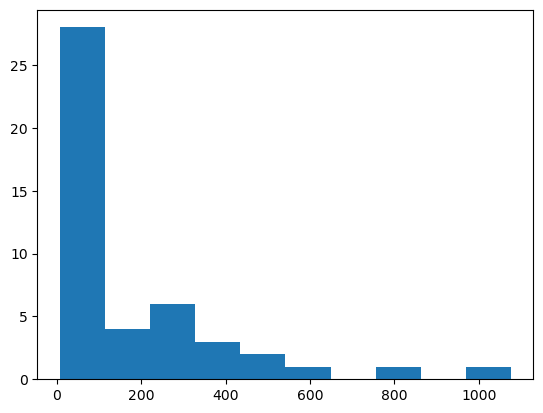

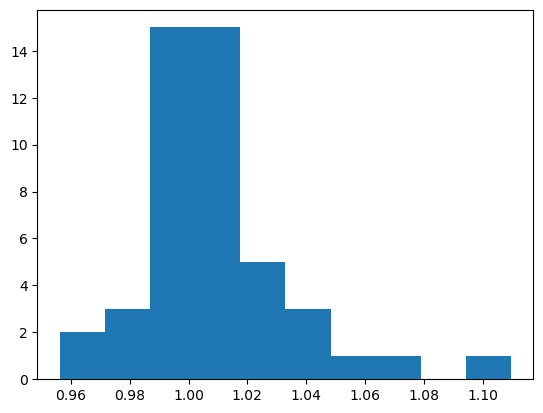

In [30]:
plt.hist(df.loc['max_abs_ratio'])
plt.show()

plt.hist(df.loc['avg_ratio'])
plt.show()